# Customer Segmentation Problem

In [81]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.cluster import KMeans

In [82]:
# Loading the data from csv
retail_data = pd.read_csv('../OnlineRetail.csv', encoding='unicode_escape')

In [83]:
# Checking the shape of the data
retail_data.shape

(541909, 8)

In [84]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [85]:
retail_data.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [86]:
# checking for unique values
retail_data.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

In [87]:
retail_data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [88]:
# Converting InvoiceDate to date-time format
retail_data['InvoiceDate'] = pd.to_datetime(retail_data['InvoiceDate'])

In [89]:
# Getting only UK data
retail_uk = retail_data.query("Country=='United Kingdom'").reset_index(drop=True)
retail_uk.shape

(495478, 8)

In [90]:
# Creating a generic user dataframe
retail_user = pd.DataFrame(retail_data['CustomerID'].unique())
retail_user.columns = ['CustomerID']

In [91]:
retail_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


## Recency

In [92]:
# Get the max purchase date for each customer and create a dataframe with it
retail_max_purchase = retail_uk.groupby('CustomerID')['InvoiceDate'].max().reset_index()
retail_max_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [93]:
retail_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [94]:
# Creating recency column
retail_max_purchase['recency'] = (retail_max_purchase['MaxPurchaseDate'].max() - retail_max_purchase['MaxPurchaseDate']).dt.days

In [95]:
retail_max_purchase.head()

,CustomerID,MaxPurchaseDate,recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [96]:
# Merging recency with user dataframe
retail_user = pd.merge(retail_user, retail_max_purchase[['CustomerID','recency']], on='CustomerID')

In [97]:
retail_user.head()

,CustomerID,recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


In [98]:
retail_user.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerID,3950.0,15562.029367,1576.848325,12346.0,14208.25,15571.5,16913.75,18287.0
recency,3950.0,90.778481,100.230349,0.0,16.00,49.0,142.00,373.0


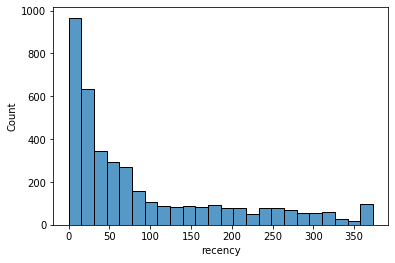

In [99]:
sns.histplot(data=retail_user, x='recency');

In [100]:
# Creating clusters using recency

sse={}
retail_recency = retail_user[['recency']]
for k in range(1,10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(retail_recency)
    retail_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_

In [101]:
sse

{1: 39672139.17088604,
 2: 8179631.146517284,
 3: 3895549.0456194943,
 4: 2220701.5255675167,
 5: 1370402.6181194652,
 6: 951338.9395960642,
 7: 715946.6871091675,
 8: 550477.1349966953,
 9: 416515.0871131742}

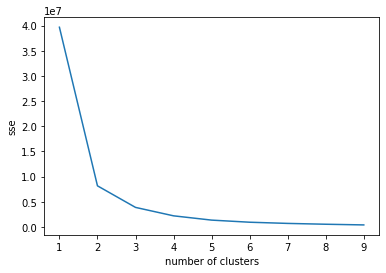

In [102]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('number of clusters')
plt.ylabel('sse')
plt.show()

- Looking at the elbow graph above we can see that 3 is good cluster but we can go lower or higher according to business requirement.

In [103]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(retail_recency)
retail_user['RecencyCluster'] = kmeans.predict(retail_recency)

In [104]:
retail_user.head()

,CustomerID,recency,RecencyCluster
0,17850.0,301,2
1,13047.0,31,3
2,13748.0,95,0
3,15100.0,329,2
4,15291.0,25,3


In [105]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [118]:
# new_cluster_field_name = 'new_'+'RecencyCluster'

In [119]:
# df_new = retail_user.groupby('RecencyCluster')['recency'].mean().reset_index()
# df_new

In [120]:
# df_new = df_new.sort_values(by='recency', ascending=False).reset_index(drop=True)
# df_new

In [121]:
# df_new['index'] = df_new.index

In [122]:
# retail_user.head()

In [123]:
# df_new

In [124]:
# df_final = pd.merge(retail_user, df_new[['RecencyCluster','index']], on='RecencyCluster')
# df_final.head()

In [125]:
# df_final = df_final.drop('RecencyCluster', axis=1)
# df_final.head()

In [126]:
# df_final = df_final.rename(columns={'index':'RecencyCluster'})
# df_final.head()

In [127]:
retail_user = order_cluster('RecencyCluster', 'recency',retail_user,False)

In [128]:
retail_user.head()

,CustomerID,recency,RecencyCluster
0,17850.0,301,0
1,15100.0,329,0
2,18074.0,373,0
3,16250.0,260,0
4,13747.0,373,0


In [166]:
retail_user.groupby('RecencyCluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,461.0,306.563991,40.323404,247.0,269.00,301.0,339.0,373.0
1,582.0,186.675258,32.772349,133.0,157.25,184.5,213.0,246.0
2,957.0,77.849530,23.016420,48.0,59.00,73.0,94.0,132.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.0,47.0


## Frequency

In [142]:
retail_frequency = retail_uk.groupby('CustomerID')['InvoiceDate'].count().reset_index()
retail_frequency.columns = ['CustomerID','frequency']
retail_frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [145]:
# adding this data to main dataframe
retail_user = pd.merge(retail_user, retail_frequency, on='CustomerID')
retail_user.head()

,CustomerID,recency,RecencyCluster,frequency
0,17850.0,301,0,312
1,15100.0,329,0,6
2,18074.0,373,0,13
3,16250.0,260,0,24
4,13747.0,373,0,1


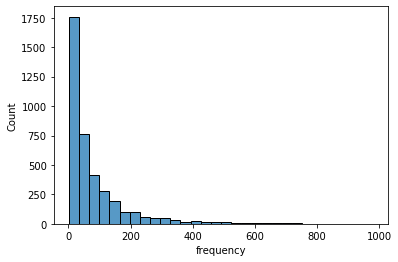

In [152]:
sns.histplot(data=retail_user[retail_user['frequency']<1000], x='frequency', bins=30);

In [153]:
kmeans = KMeans(n_clusters=4)

In [157]:
kmeans.fit(retail_user[['frequency']])

KMeans(n_clusters=4)

In [159]:
retail_user['FrequencyCluster'] = kmeans.predict(retail_user[['frequency']])

In [161]:
retail_user = order_cluster('FrequencyCluster','frequency',retail_user, True)

In [162]:
retail_user.groupby('FrequencyCluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3496.0,49.525744,44.954212,1.0,15.0,33.0,73.0,190.0
1,429.0,331.221445,133.856510,191.0,228.0,287.0,399.0,803.0
2,22.0,1313.136364,505.934524,872.0,988.5,1140.0,1452.0,2782.0
3,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


## Revenue

In [167]:
retail_user

,CustomerID,recency,RecencyCluster,frequency,FrequencyCluster
0,17850.0,301,0,312,1
1,15808.0,305,0,210,1
2,13047.0,31,3,196,1
3,14688.0,7,3,359,1
4,16029.0,38,3,274,1
...,...,...,...,...,...
3945,14056.0,0,3,1128,2
3946,14456.0,4,3,977,2
3947,12748.0,0,3,4642,3
3948,17841.0,1,3,7983,3


In [169]:
retail_uk['revenue']= retail_uk['Quantity']*retail_uk['UnitPrice']

In [170]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [175]:
retail_revenue = retail_uk.groupby('CustomerID')['revenue'].sum().reset_index()

In [177]:
retail_user = pd.merge(retail_user, retail_revenue, on='CustomerID')

In [178]:
retail_user.head()

,CustomerID,recency,RecencyCluster,frequency,FrequencyCluster,revenue
0,17850.0,301,0,312,1,5288.63
1,15808.0,305,0,210,1,3724.77
2,13047.0,31,3,196,1,3079.10
3,14688.0,7,3,359,1,5107.38
4,16029.0,38,3,274,1,50992.61


In [189]:
retail_user['revenue'].max()

256438.49000000005

In [190]:
retail_user['revenue'].min()

-4287.63

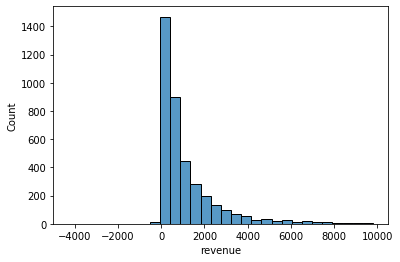

In [193]:
sns.histplot(data=retail_user[retail_user['revenue']<10000], x='revenue', bins=30);

In [179]:
kmeans = KMeans(n_clusters=4)

In [180]:
kmeans.fit(retail_user[['revenue']])

KMeans(n_clusters=4)

In [183]:
retail_user['RevenueCluster'] = kmeans.predict(retail_user[['revenue']])

In [184]:
retail_user.head()

,CustomerID,recency,RecencyCluster,frequency,FrequencyCluster,revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,3
1,15808.0,305,0,210,1,3724.77,0
2,13047.0,31,3,196,1,3079.10,0
3,14688.0,7,3,359,1,5107.38,3
4,16029.0,38,3,274,1,50992.61,2


In [185]:
retail_user = order_cluster('RevenueCluster','revenue',retail_user,True)

In [186]:
retail_user.head()

,CustomerID,recency,RecencyCluster,frequency,FrequencyCluster,revenue,RevenueCluster
0,17850.0,301,0,312,1,5288.63,1
1,14688.0,7,3,359,1,5107.38,1
2,13767.0,1,3,399,1,16945.71,1
3,15513.0,30,3,314,1,14520.08,1
4,14849.0,21,3,392,1,7904.28,1


In [187]:
retail_user.groupby('RevenueCluster')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3687.0,907.254414,921.910820,-4287.63,263.115,572.56,1258.220,4314.72
1,234.0,7760.699530,3637.173671,4330.67,5161.485,6549.38,9142.305,21535.90
2,27.0,43070.445185,15939.249588,25748.35,28865.490,36351.42,53489.790,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.250,221960.33,239199.410,256438.49


## Overall score

In [194]:
# Calculating overall score, here it is to be noted that if revenue needs have more importance than we can say 2*revenue cluster
retail_user['OverallScore']=retail_user['RecencyCluster']+retail_user['FrequencyCluster']+retail_user['RevenueCluster']

In [195]:
retail_user.head()

,CustomerID,recency,RecencyCluster,frequency,FrequencyCluster,revenue,RevenueCluster,OverallScore
0,17850.0,301,0,312,1,5288.63,1,2
1,14688.0,7,3,359,1,5107.38,1,5
2,13767.0,1,3,399,1,16945.71,1,5
3,15513.0,30,3,314,1,14520.08,1,5
4,14849.0,21,3,392,1,7904.28,1,5


In [196]:
retail_user.groupby('OverallScore')[['recency','frequency','revenue']].mean()

,recency,frequency,revenue
OverallScore,,,
0,306.781182,21.844639,301.541291
1,187.416667,32.493056,493.838439
2,79.163597,46.860238,866.835603
3,20.689610,68.419590,1091.416414
4,14.892617,271.755034,3607.097114
5,9.662162,373.290541,9136.946014
6,7.740741,876.037037,22777.914815
7,1.857143,1272.714286,103954.025714
8,1.333333,5917.666667,42177.930000


- The above clearly shows that the customers with overall score of 8 are more important than that with score 0.
    - For instance, the customers with score 8 have a mean recency of 1.33 and frequency of 5917.67 and revenue of 42177.93

## Segmentation

In [197]:
retail_user['Segment']= 'Low-Value'
retail_user.loc[retail_user['OverallScore']>2,'Segment']='Mid-Value'
retail_user.loc[retail_user['OverallScore']>4,'Segment']='High-Value'

In [198]:
retail_user.head()

,CustomerID,recency,RecencyCluster,frequency,FrequencyCluster,revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,1,2,Low-Value
1,14688.0,7,3,359,1,5107.38,1,5,High-Value
2,13767.0,1,3,399,1,16945.71,1,5,High-Value
3,15513.0,30,3,314,1,14520.08,1,5,High-Value
4,14849.0,21,3,392,1,7904.28,1,5,High-Value


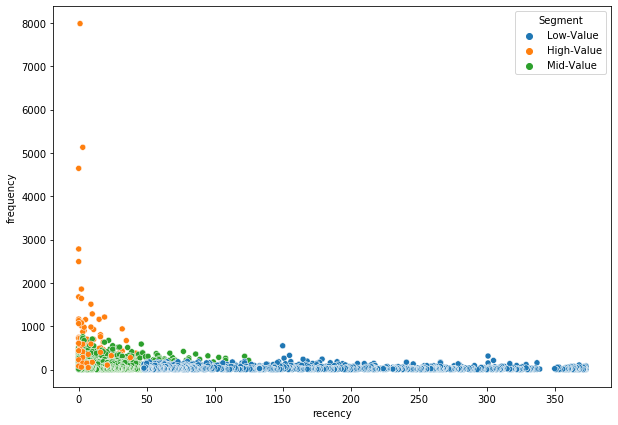

In [216]:
fig,ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=retail_user, x= 'recency', y='frequency',hue='Segment', ax=ax);

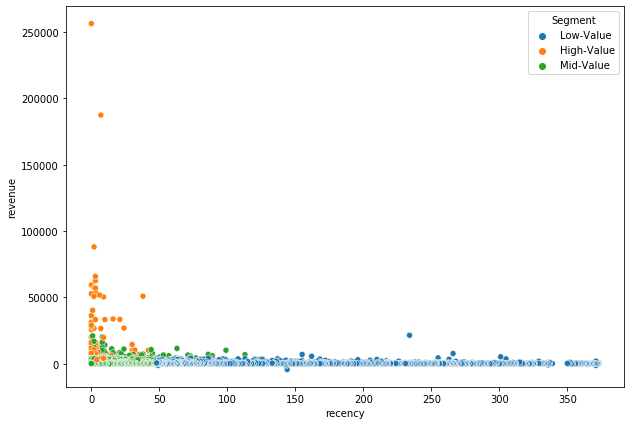

In [219]:
fig,ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=retail_user, x= 'recency', y='revenue',hue='Segment', ax=ax);

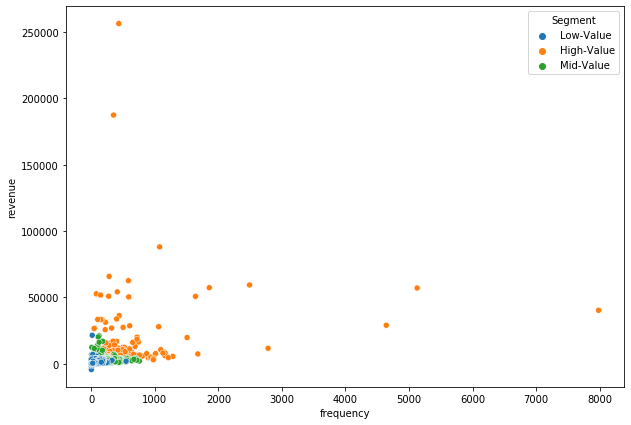

In [223]:
fig,ax = plt.subplots(figsize=(10,7))
sns.scatterplot(data=retail_user, x= 'frequency', y='revenue',hue='Segment', ax=ax);

- Strategies taken for each customer segment type are:
    - High Value: Improve retention
    - Mid Value: Improve retention + Increase frequency
    - Low Value: Increaase frequency

#### Improvements - try implementing Jenks Natural breaking algorithm